# Removing High-Quantity Samples

We showcase our experimental outcomes concerning the obfuscation technique involving the elimination of samples with substantial quantities of geochemical features. We demonstrate that, in comparison to previous obfuscation approaches, this method notably impairs data utility when targeting high-quantity samples. 

In [1]:
# Import necessary libraries
import shapely
import warnings
import os
import numpy as np
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)  # Suppress Shapely warning
np.warnings.filterwarnings('ignore')  # Suppress NumPy warnings
import sys
import random
import gc

sys.path.append('..')  # Add parent directory to the system path

# Import custom module 'minerals'
from minerals import *

# Set path and other variables
path = '..'  # Base directory path
side_len = 50  # Side length of grid cells
l = 5  # Value of 'l' for analysis

# Read data using the 'read_files' function from the 'minerals' module
df = read_files(path)

# Load mineral grid data and sampling tenement data
df_minerals_grid = pd.read_csv('../data/df_minerals_grid_'+str(side_len)+'_v2.csv')
df_sampling_tenement = pd.read_csv('../data/df_sampling_tenement_'+str(side_len)+'_v2.csv')

# Sort the mineral grid data based on coordinates
df_minerals_grid = df_minerals_grid.sort_values(by=['coords_x','coords_y'], ignore_index=True)

# Create additional columns for original probability values and error calculation
df_minerals_grid['proba_prospectivity_orig-40'] = df_minerals_grid['proba_prospectivity-40']
df_minerals_grid['abs_error_orig'] = 0


### Figure 24: Prospectivity heatmap of removing n% high-quantity samples.

In [2]:
def display_graph2(axi, df, tenid, tit,  l=5):
    
    
    
   
    df['proba' + tenid] = df['proba_prospectivity_'+  tenid] * 2
   
    a = []
    text_a = []
    for y in sorted(np.unique(df.coords_y.tolist()), reverse=True):
        ll = []
        text_ll = []
        for x in sorted(np.unique( df.coords_x.tolist())):
            ll.append(df[( df.coords_x == x) & ( df.coords_y == y)]['proba'+tenid ].values[0])
            
        a.append(ll)
        

    #print (text_a)
    q = sns.heatmap(a,  fmt="", linewidth=0.5, center=1, ax=axi, cmap='bwr')

    #axi.set_xticklabels(sorted([round(x, 2) for x in np.unique( df.coords_x.tolist())]), rotation=30),.5
    #axi.set_yticklabels(sorted([round(x, 2) for x in np.unique( df.coords_y.tolist())], reverse=True),rotation='horizontal')
    
    if len(df)>1000:
        step =5
    else:
        step=4

    
    xlab = sorted([round(x, 2) for x in np.unique(df.coords_x.tolist())])
    lx = np.arange(len(xlab))
    axi.tick_params(axis='x', labelsize=14, rotation=30)
    axi.set(xticks=lx[0::step], xticklabels=xlab[0::step])
    
    ylab = sorted([round(x, 2) for x in np.unique(df.coords_y.tolist())])
    ly = np.arange(len(ylab))
    axi.tick_params(axis='y', labelsize=14, rotation=0)
    axi.set(yticks=ly[0::step], yticklabels=ylab[0::step])  # , rotation=30)

    
    axi.set_xlabel('Longitude',fontsize=14)
    axi.set_ylabel('Latitude',fontsize=14)
    #axi.set_title(tit,  fontsize=22)
        
        
    q.collections[0].colorbar.set_ticks([0, 0.5, 1, 1.5, 2])
    q.collections[0].colorbar.set_ticklabels(['0', '0.25', '0.5', '0.75', '1'])
    q.collections[0].colorbar.ax.tick_params(labelsize=20)
    axi.collections[0].colorbar.set_label("Prospectivity probability", size=20)

74it [00:05, 12.97it/s]
74it [00:00, 4649.10it/s]


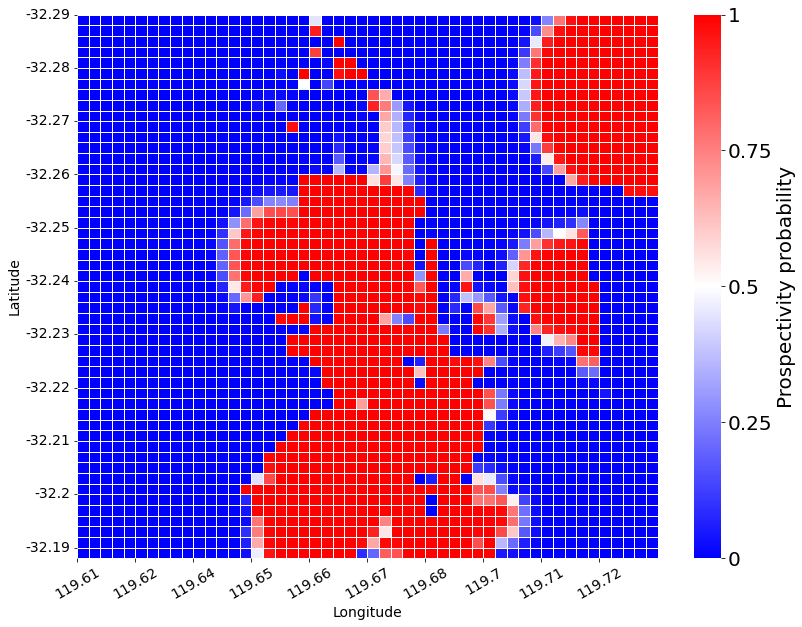

In [3]:
# Define column names for relevant data
cols = ['coords_x', 'coords_y', 'proba_prospectivity-40', 'tenements']

# Set the value of 'l'
l = 5

# Construct the output directory path based on 'side_len' and 'l'
directory1 = path + '/data_' + str(side_len) + '/out_l=' + str(l)

# Initialize a dictionary to store all required sampling data
allsamplingneeded = {}

# Define weights for each chemical component
weight_model = {'komatiite':2.672682,'ultramafic':2.371440,' mafic':0.826142,'crust':2.288389, 'Cr':0.144607, 'Cu':0.082966,'Ni':0.437637}



# Iterate through the rows of 'df' to calculate sampling needs
allsamplingneeded = {}
df['sampling'] = df['sampling'].fillna(0)
for id, row in df['sampling'].iterrows():
    allsamplingneeded[id] = 0
    for chem in ['Cr', 'Cu', 'Ni']:
        allsamplingneeded[id] += weight_model[chem] * row[chem]

# Sort the sampling needs in descending order
allsamplingneeded_sorted = list(dict(sorted(allsamplingneeded.items(), key=lambda item: item[1], reverse=True)).keys())

# Initialize a DataFrame to store results
meanerrs = pd.DataFrame()

# Initialize a dictionary to store metrics
dico_metrics = {'high': {}}

# Iterate through different ratios
for ratio in [0.01]:
#for ratio in np.arange(0.1, 0.12, .01):
    tenement_id = '_highest_sampling_' + str(ratio)
    tit = 'Removing top-quantity samples (' + str(ratio*100) + '%)\n'
    dico_metrics['high'][ratio*100] = {}

    # Get the ratio% highest sampling
    highest_sampling_list = allsamplingneeded_sorted[:int(len(allsamplingneeded_sorted) * ratio)]
    
    conf_loss_count = (len(df_sampling_tenement) - len(highest_sampling_list)) / len(df_sampling_tenement)
    
    # Perform analysis and calculations
    df_res = remove_and_recalculate_prospectivy(df, df_minerals_grid, tenement_id, directory1, highest_sampling_list)
    df_res = df_res.sort_values(by=['coords_x', 'coords_y'], ignore_index=True)
    df_res['abs_error_'+tenement_id.replace(' ', '')] = (df_res['proba_prospectivity_orig-40'] - df_res['proba_prospectivity-40']).abs()
    df_res = df_res.rename(columns={'proba_prospectivity_orig-40': 'proba_prospectivity_orig', 'proba_prospectivity-40': 'proba_prospectivity_' + tenement_id.replace(' ', '')})

    tit += 'Conf_loss_count=' + str(round(conf_loss_count, 3)) + '\n'
    dico_metrics['high'][ratio*100]['Conf_loss_count'] = conf_loss_count
    
    # Iterate through different values of 'l' and calculate mean absolute error
    for l in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 77]:
        klargest_errors = df_res['abs_error_' + tenement_id.replace(' ', '')].nlargest(l).values
        meanerr = str(round(np.mean(klargest_errors), 3))
        tit += "loss_MAE-" + str(l) + "=" + meanerr + ' '
        dico_metrics['high'][ratio*100]['loss_MAE-' + str(l)] = np.mean(klargest_errors)

    # Generate and display visualization
    f, ax = plt.subplots(1, 1, figsize=(13, 10))
    display_graph2(ax, df_res, tenement_id, tit, l=5)
    filename = 'size_' + str(side_len) + '_highest_sampling_' + str(ratio) + '_l=' + str(5) + '.png'
    
    plt.show()
    plt.close()



### Figure 23: Utility loss measured by top-𝐿 mean absolute error of random down-sampling with various values of down- sampling percentage and 𝐿.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:11<00:00, 27.35s/it]


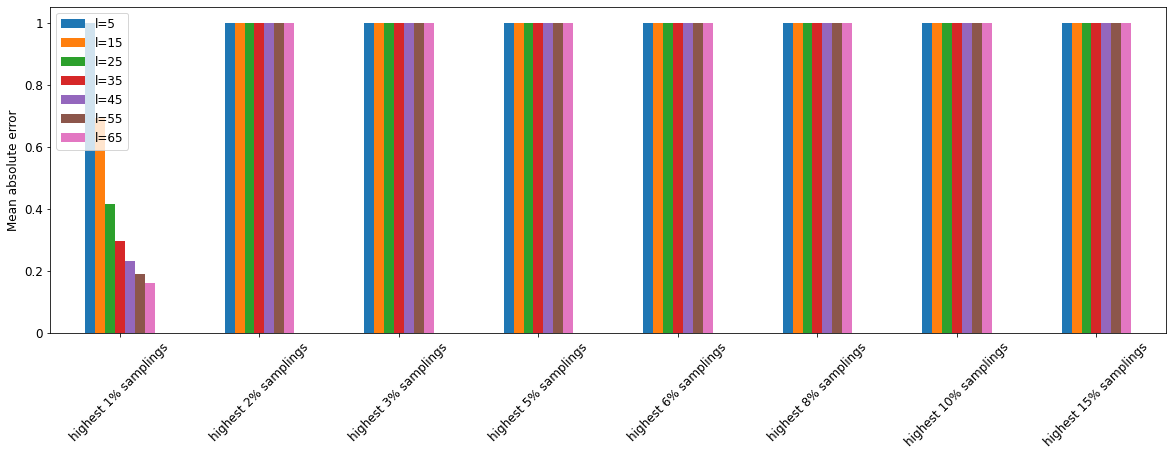

In [7]:

np.warnings.filterwarnings('ignore')


list_tens=[]
names_xticks = []
for ratio in [.01,.02, .03,  .05,.06,.08, .10,.15]:
    list_tens.append('_highest_sampling_'+str(ratio))
    names_xticks.append('highest '+str(int(ratio*100))+'% samplings')
    
meanerrs =pd.DataFrame()
for l in tqdm( [5,15,25,35, 45,55,65]):
    
    meanerrs_tmp =pd.DataFrame()
    
    
    for tenement_id in list_tens:
        try: 
            df_trn = pd.read_csv('../data_50/out_l=5/tenement_no_'+tenement_id+'.csv')
            df_trn['abs_error_'+tenement_id] = (df_trn['proba_prospectivity-40']-df_trn['proba_prospectivity_orig-40']).abs()
            tenid = tenement_id.replace(' ','')
            klargest_errors = df_trn['abs_error_'+tenid].nlargest(l).values
            meanerrs_tmp = meanerrs_tmp.append({'id':'delete'+tenement_id, 'l='+str(l) : round(np.mean(klargest_errors),3)}, ignore_index=True)
        except:
            print (l, tenement_id,' error')
    if l ==5:
        meanerrs = meanerrs_tmp.copy()
    else:
        meanerrs = pd.merge(meanerrs, meanerrs_tmp, on="id")


meanerrs = meanerrs.sort_values(by=['l=5'])
plt.rcParams["figure.figsize"] = (20,6)

fig, ax = plt.subplots(figsize = (20,6))
meanerrs[['l='+str(l) for l in [5,15,25,35, 45,55,65]]].plot(kind='bar', ax =ax)

ax.set_ylabel('Mean absolute error', fontsize=12)
ax.legend(fontsize=12)
ax.set_yticklabels([0,0.2,0.4,0.6,0.8, 1] ,fontsize=12)
ax.set_xticklabels(names_xticks, rotation=45, fontsize=12)
plt.show()